Let's load the validation images

In [28]:
import re
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [29]:
# Load the CSV file
file_path = "full_img_test.csv" 
df = pd.read_csv(file_path)
df["image_path"] = df["image_path"].str.replace(r".*(Breast_Images[\\/])", r"\1", regex=True)


# Read 20% of normal images
random.seed(42)

# Define the path to the folder and get files of normal folder
folder_path = "Breast_Images/normal/"
# List all files in the directory
all_files = os.listdir(folder_path)
# Filter files that do not contain '_mask' in their name
non_mask_files = [f for f in all_files if "_mask" not in f]
# Select 20% of the images
num_selected = int(len(non_mask_files) * 0.2)
selected_files = random.sample(non_mask_files, num_selected)
# Print the list of selected files
print(non_mask_files)

df_normal = pd.DataFrame(selected_files, columns=['image_path'])
df_normal['label'] = 0
df_normal['image_path'] = folder_path + df_normal['image_path']



df_normal

df = pd.concat([df, df_normal], ignore_index=True)

df.to_csv("full_img_test_relative_routes.csv")


['normal (1).png', 'normal (10).png', 'normal (100).png', 'normal (101).png', 'normal (102).png', 'normal (103).png', 'normal (104).png', 'normal (105).png', 'normal (106).png', 'normal (107).png', 'normal (108).png', 'normal (109).png', 'normal (11).png', 'normal (110).png', 'normal (111).png', 'normal (112).png', 'normal (113).png', 'normal (114).png', 'normal (115).png', 'normal (116).png', 'normal (117).png', 'normal (118).png', 'normal (119).png', 'normal (12).png', 'normal (120).png', 'normal (121).png', 'normal (122).png', 'normal (123).png', 'normal (124).png', 'normal (125).png', 'normal (126).png', 'normal (127).png', 'normal (128).png', 'normal (129).png', 'normal (13).png', 'normal (130).png', 'normal (131).png', 'normal (132).png', 'normal (133).png', 'normal (14).png', 'normal (15).png', 'normal (16).png', 'normal (17).png', 'normal (18).png', 'normal (19).png', 'normal (2).png', 'normal (20).png', 'normal (21).png', 'normal (22).png', 'normal (23).png', 'normal (24).png'

In [30]:
# Define source and destination directories
source_folder = "Breast_Images/normal/"  # Update with actual path
destination_folder = "Breast_Images_Test/normal/"  # Update with actual path

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# List all non-mask files
all_files = os.listdir(source_folder)
non_mask_files = [f for f in all_files if "_mask" not in f]  # Exclude mask images

# Select 20% of images


# Copy files to the destination folder
for file_name in selected_files:
    src_path = os.path.join(source_folder, file_name)
    dst_path = os.path.join(destination_folder, file_name)
    shutil.copy(src_path, dst_path)

In [31]:
df

,image_path,label
0,Breast_Images/benign\benign (58).png,1
1,Breast_Images/benign\benign (131).png,1
2,Breast_Images/benign\benign (113).png,1
3,Breast_Images/benign\benign (47).png,1
4,Breast_Images/benign\benign (155).png,1
...,...,...
133,Breast_Images/normal/normal (49).png,0
134,Breast_Images/normal/normal (84).png,0
135,Breast_Images/normal/normal (43).png,0
136,Breast_Images/normal/normal (121).png,0


Load the first image and show it

In [32]:
first_image_path = df['image_path'].iloc[0]
print(first_image_path)
first_image = cv2.imread(first_image_path)

Breast_Images/benign\benign (58).png


### Test the model for the first image

In [33]:
# Load the CNN model
model_path = "tumor_classifier.h5"  # Ensure this is correct
model = load_model(model_path)

# Model expected input size
IMG_SIZE = (128, 128)  # Update if your model expects a different input size

C:\Users\adral\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\adral\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [34]:
# Path to the test image
test_image_path =  first_image_path # Update with the actual image path

# Function to preprocess the image
def preprocess_image(image_path, target_size=IMG_SIZE):
    img = cv2.imread(image_path)  # Load the image
    if img is None:
        raise FileNotFoundError(f"Error: Image not found at {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize to match model input
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Preprocess the test image
processed_image = preprocess_image(test_image_path)

### Make a prediction

Verify the input shape

In [35]:
print(model.input_shape)

(None, 128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Prediction: Malignant (Confidence: 0.80)


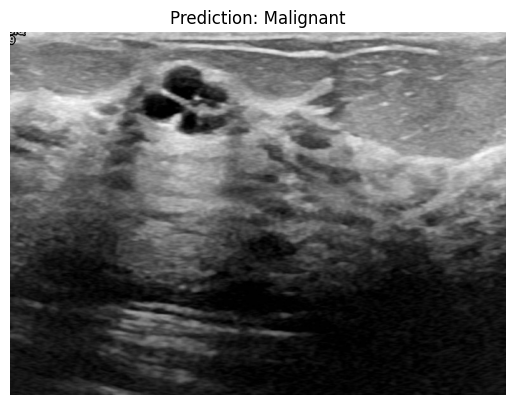

In [36]:
# Make a prediction
prediction = model.predict(processed_image)

# Interpret prediction
if prediction.shape[1] == 1:  # Binary classification
    result = "Tumor Detected" if prediction[0][0] > 0.5 else "No Tumor Detected"
    confidence = prediction[0][0]
else:  # Multi-class classification
    classes = ["Benign", "Malignant"]
    predicted_class = np.argmax(prediction)
    result = classes[predicted_class]
    confidence = prediction[0][predicted_class]

# Print result
print(f"Prediction: {result} (Confidence: {confidence:.2f})")

# Display the image with the prediction
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Prediction: {result}")
plt.axis("off")
plt.show()


### Full file prediction

In [37]:
# Load the CSV file with image paths
csv_path = "full_img_test_relative_routes.csv"  # Update with actual file path
df = pd.read_csv(csv_path)

# Ensure paths are correctly formatted (fixing backslashes if needed)
df["image_path"] = df["image_path"].str.replace("\\", "/")
df

,Unnamed: 0,image_path,label
0,0,Breast_Images/benign/benign (58).png,1
1,1,Breast_Images/benign/benign (131).png,1
2,2,Breast_Images/benign/benign (113).png,1
3,3,Breast_Images/benign/benign (47).png,1
4,4,Breast_Images/benign/benign (155).png,1
...,...,...,...
133,133,Breast_Images/normal/normal (49).png,0
134,134,Breast_Images/normal/normal (84).png,0
135,135,Breast_Images/normal/normal (43).png,0
136,136,Breast_Images/normal/normal (121).png,0


In [38]:
# Prepare lists for predictions
X_test = []
valid_image_paths = []

# Process all images in the dataset
for path in df["image_path"]:
    img = preprocess_image(path)
    if img is not None:
        X_test.append(img)
        valid_image_paths.append(path)  # Keep only valid paths

# Convert list to NumPy array
X_test = np.vstack(X_test)

# Run predictions
predictions = model.predict(X_test)

# Convert predictions to class labels
if predictions.shape[1] == 1:  # Binary classification
    y_pred = (predictions > 0.5).astype(int).flatten()
else:  # Multi-class classification
    y_pred = np.argmax(predictions, axis=1)

# Store predictions in the DataFrame
df = df[df["image_path"].isin(valid_image_paths)]  # Keep only valid rows
df["prediction"] = y_pred

# Save the results to a CSV
df.to_csv("predictions.csv", index=False)

# Print summary statistics
print("Predictions completed.")
print(df.head())

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Predictions completed.
   Unnamed: 0                             image_path  label  prediction
0           0   Breast_Images/benign/benign (58).png      1           1
1           1  Breast_Images/benign/benign (131).png      1           0
2           2  Breast_Images/benign/benign (113).png      1           2
3           3   Breast_Images/benign/benign (47).png      1           0
4           4  Breast_Images/benign/benign (155).png      1           0


Accuracy: 0.2681
Confusion Matrix:
 [[17  1  8]
 [42 11 22]
 [10 18  9]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.25      0.65      0.36        26
      Benign       0.37      0.15      0.21        75
   Malignant       0.23      0.24      0.24        37

    accuracy                           0.27       138
   macro avg       0.28      0.35      0.27       138
weighted avg       0.31      0.27      0.24       138



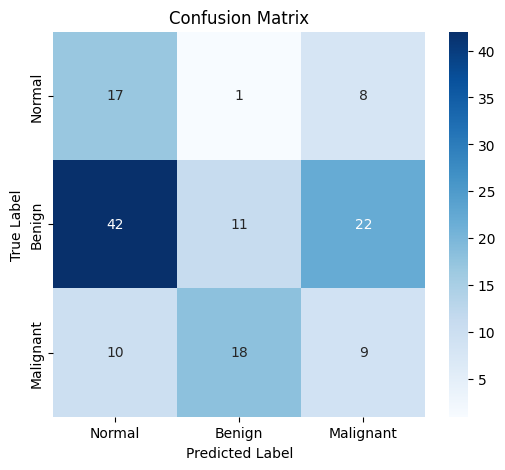

In [39]:
# Show model performance if ground truth labels exist
if "label" in df.columns:
    y_true = df["label"].values
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["Normal", "Benign", "Malignant"])

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)


    # Define class labels (match the model output)
    class_labels = ["Normal", "Benign", "Malignant"]

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Show plot
    plt.show()
